<a href="https://colab.research.google.com/github/dhgrassi/Grupo-de-Estudos-DS/blob/main/Titanic_Kaggle_Challenge_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# libraries and dataset import

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

from google.colab import files
uploaded = files.upload()
df = pd.read_csv('train.csv')
df.head()


Saving train.csv to train.csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#checking for non-nulls and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


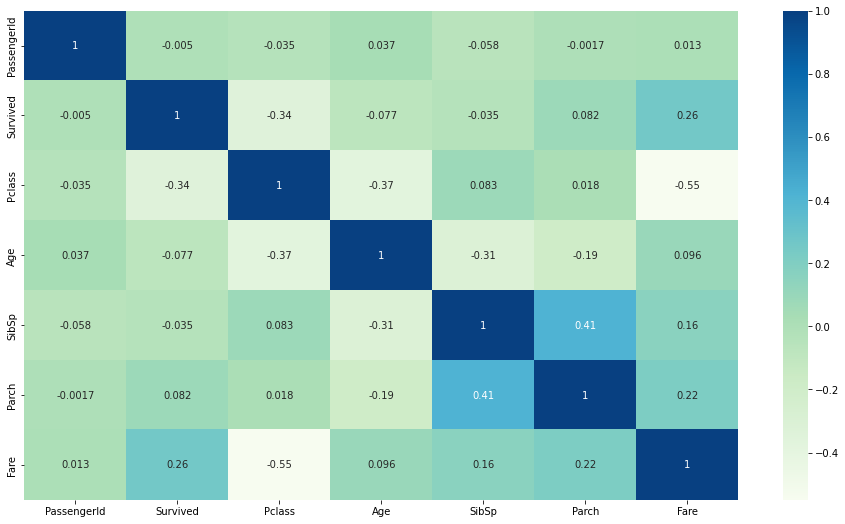

In [ ]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),
            annot=True,
            cmap="GnBu")

#Numeric correlation shows that survived or not has stronger correlation with Pclass and Fare

In [8]:
#Transforming sex in numeric variable

sexcode = df['Sex'].astype("category").cat.codes

df.insert(1,"sexcode", sexcode.astype(float))
df

,PassengerId,sexcode,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,1.0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,0.0,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,0.0,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,0.0,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,1.0,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,1.0,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,0.0,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0.0,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1.0,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [9]:
#Removing columns with no correlation
df_mod = df.drop(columns=['Name','Sex','Ticket','Cabin','Embarked'])

#Reordening columns
new_cols=["PassengerId","sexcode","Pclass","Age","SibSp","Parch","Fare","Survived"]
df_mod=df_mod[new_cols]

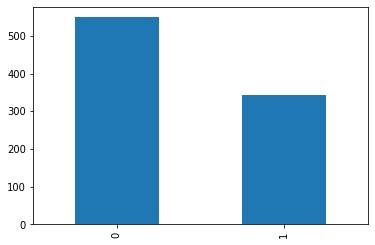

In [ ]:
#Survived (1) and non survived (0) count
df_mod['Survived'].value_counts().plot(kind = 'bar')

In [ ]:
df_mod['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [10]:
#changing non-numeric data from 'age' column using InterativeImputer
#A more sophisticated approach is to use the IterativeImputer class, which models each feature with missing values as a function of other features, and uses 
#that estimate for imputation. It does so in an iterated round-robin fashion: at each step, a feature column is designated as output y and the other feature 
#columns are treated as inputs X. A regressor is fit on (X, y) for known y. Then, the regressor is used to predict the missing values of y. This is done for 
#each feature in an iterative fashion, and then is repeated for max_iter imputation rounds. The results of the final imputation round are returned.
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman',random_state=0)
df_mod=imp.fit_transform(df_mod)

[IterativeImputer] Completing matrix with shape (891, 8)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.03
[IterativeImputer] Change: 35.23384980287067, scaled tolerance: 0.891 
[IterativeImputer] Ending imputation round 2/10, elapsed time 0.04
[IterativeImputer] Change: 0.0, scaled tolerance: 0.891 
[IterativeImputer] Early stopping criterion reached.


In [11]:
#checking non-nulls after interative imputer. Age nan were replaced by values
df_final = pd.DataFrame(df_mod, columns =["PassengerId","sexcode","Pclass","Age","SibSp","Parch","Fare","Survived"])
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    float64
 1   sexcode      891 non-null    float64
 2   Pclass       891 non-null    float64
 3   Age          891 non-null    float64
 4   SibSp        891 non-null    float64
 5   Parch        891 non-null    float64
 6   Fare         891 non-null    float64
 7   Survived     891 non-null    float64
dtypes: float64(8)
memory usage: 55.8 KB


In [14]:
#Conver to numpy array in order to input in tensorflow
nparray = df_final.to_numpy()

In [16]:
features = (nparray[:,0:6]).astype(float)
targets = (nparray[:,7]).astype(int)  ## bynary problem
print("Features = ", features.shape)
print("Targets = ", targets.shape)

Features =  (891, 6)
Targets =  (891,)


In [18]:
#splitting in train and test
X_train, X_val, y_train, y_val = train_test_split(features, targets, 
                                     test_size=0.25, random_state=0)
print("Training:", len(X_train))
print("Validation:", len(X_val))

Training: 668
Validation: 223


In [19]:
#checking train and test data
X_train

array([[106.        ,   1.        ,   3.        ,  28.        ,
          0.        ,   0.        ],
       [ 69.        ,   0.        ,   3.        ,  17.        ,
          4.        ,   2.        ],
       [254.        ,   1.        ,   3.        ,  30.        ,
          1.        ,   0.        ],
       ...,
       [630.        ,   1.        ,   3.        ,  29.14643446,
          0.        ,   0.        ],
       [560.        ,   0.        ,   3.        ,  36.        ,
          1.        ,   0.        ],
       [685.        ,   1.        ,   2.        ,  60.        ,
          1.        ,   1.        ]])

In [20]:
#binaty response - did not survive (0) or survived (1)
y_train

array([0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,

In [21]:
#Shallow MLP with 1 layer
model1 = keras.Sequential(
 [
   keras.layers.Dense(8, activation="relu", input_shape=(X_train.shape[-1],)),
   keras.layers.Dense(1, activation="sigmoid"),
 ]
)

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 56        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [22]:
metrics = [
    keras.metrics.FalseNegatives(name="fn"),
    keras.metrics.FalsePositives(name="fp"),
    keras.metrics.TrueNegatives(name="tn"),
    keras.metrics.TruePositives(name="tp"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

# compilamos o modelo utilizando:
#- um otimizador SGD
#- a função de perda entropia cruzada
#- as métricas acima
model1.compile(
    optimizer=keras.optimizers.SGD(), loss="binary_crossentropy", metrics=metrics
)

In [23]:
batch_size = 10
epochs = 30

In [24]:
len(X_train)/batch_size

66.8

In [25]:
history1 = model1.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,  ## mostra as iteracoes
    validation_data=(X_val, y_val),
)

Epoch 1/30
67/67 [==============================] - 3s 16ms/step - loss: 5.9687 - fn: 251.0000 - fp: 6.0000 - tn: 404.0000 - tp: 7.0000 - precision: 0.5385 - recall: 0.0271 - val_loss: 0.6947 - val_fn: 82.0000 - val_fp: 1.0000 - val_tn: 138.0000 - val_tp: 2.0000 - val_precision: 0.6667 - val_recall: 0.0238
Epoch 2/30
67/67 [==============================] - 0s 3ms/step - loss: 0.7132 - fn: 254.0000 - fp: 3.0000 - tn: 407.0000 - tp: 4.0000 - precision: 0.5714 - recall: 0.0155 - val_loss: 0.6837 - val_fn: 83.0000 - val_fp: 1.0000 - val_tn: 138.0000 - val_tp: 1.0000 - val_precision: 0.5000 - val_recall: 0.0119
Epoch 3/30
67/67 [==============================] - 0s 3ms/step - loss: 0.6980 - fn: 254.0000 - fp: 4.0000 - tn: 406.0000 - tp: 4.0000 - precision: 0.5000 - recall: 0.0155 - val_loss: 0.6824 - val_fn: 83.0000 - val_fp: 3.0000 - val_tn: 136.0000 - val_tp: 1.0000 - val_precision: 0.2500 - val_recall: 0.0119
Epoch 4/30
67/67 [==============================] - 0s 3ms/step - loss: 0.6987

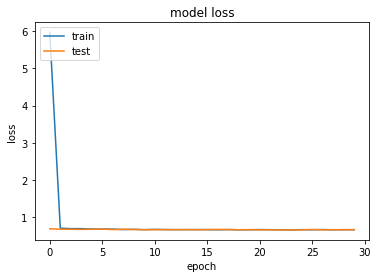

In [26]:
plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [27]:
# Computando as métricas para a validacao
score = model1.evaluate(X_val, y_val, verbose=0)

In [28]:
print("Perda (entropia cruzada): ", score[0])
print("Falsos negativos: ", score[1])
print("Falsos positivos: ", score[2])
print("Verdadeiros negativos: ", score[3])
print("Verdadeiros positivos: ", score[4])
print("Precisao: ", score[5])
print("Revocacao: ", score[6])

Perda (entropia cruzada):  0.6730109453201294
Falsos negativos:  84.0
Falsos positivos:  0.0
Verdadeiros negativos:  139.0
Verdadeiros positivos:  0.0
Precisao:  0.0
Revocacao:  0.0


The model classified everybody as a negative (139 true but 84 false). For NN, it is recommended to normalize or standardize data that could present a very different scaling - in this example we can notice that 'age' and 'fare' have very different magnitudes, and that could lead to a wrong classification by the NN.

In [29]:
#normalizing

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train -= mean
X_val -= mean

X_train /= std
X_val /= std

In [33]:
counts_train = np.bincount(y_train)
# vamos ponderar o total de cada classe e formar um peso
peso_0 = round(1.0 - (counts_train[0]/len(X_train)), 2)
peso_1 = round(1.0 - (counts_train[1]/len(X_train)), 2)
print("pesos: ", peso_0, peso_1)

# ponderacao das classes
class_weight = {0: peso_0, 1: peso_1}

pesos:  0.39 0.61


In [34]:
#improved Shallow MLP with 1 layer
model2 = keras.Sequential(
 [
   keras.layers.Dense(8, activation="relu", input_shape=(X_train.shape[-1],)),
   keras.layers.Dense(1, activation="sigmoid"),
 ]
)

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 56        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [36]:
model2.compile(
    optimizer=keras.optimizers.SGD(), loss="binary_crossentropy", metrics=metrics
)
history2 = model2.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
)

Epoch 1/30
67/67 [==============================] - 2s 14ms/step - loss: 0.3453 - fn: 236.0000 - fp: 150.0000 - tn: 399.0000 - tp: 106.0000 - precision: 0.4141 - recall: 0.3099 - val_loss: 0.6969 - val_fn: 45.0000 - val_fp: 58.0000 - val_tn: 81.0000 - val_tp: 39.0000 - val_precision: 0.4021 - val_recall: 0.4643
Epoch 2/30
67/67 [==============================] - 0s 3ms/step - loss: 0.3298 - fn: 126.0000 - fp: 147.0000 - tn: 263.0000 - tp: 132.0000 - precision: 0.4731 - recall: 0.5116 - val_loss: 0.6745 - val_fn: 35.0000 - val_fp: 56.0000 - val_tn: 83.0000 - val_tp: 49.0000 - val_precision: 0.4667 - val_recall: 0.5833
Epoch 3/30
67/67 [==============================] - 0s 3ms/step - loss: 0.3176 - fn: 110.0000 - fp: 141.0000 - tn: 269.0000 - tp: 148.0000 - precision: 0.5121 - recall: 0.5736 - val_loss: 0.6564 - val_fn: 31.0000 - val_fp: 53.0000 - val_tn: 86.0000 - val_tp: 53.0000 - val_precision: 0.5000 - val_recall: 0.6310
Epoch 4/30
67/67 [==============================] - 0s 3ms/step

In [37]:
#metrics for validation
score2 = model2.evaluate(X_val, y_val, verbose=0)
print("Falsos negativos: ", score2[1])
print("Falsos positivos: ", score2[2])
print("Verdadeiros negativos: ", score2[3])
print("Verdadeiros positivos: ", score2[4])
print("Precisao: ", score2[5])
print("Revocacao: ", score2[6])

Falsos negativos:  26.0
Falsos positivos:  25.0
Verdadeiros negativos:  114.0
Verdadeiros positivos:  58.0
Precisao:  0.6987951993942261
Revocacao:  0.6904761791229248


Model performance got better after normalization

In [38]:
#adding more layers
model3 = keras.Sequential(
 [
    keras.layers.Dense(4, activation="relu", input_shape=(X_train.shape[-1],)),
    keras.layers.Dense(4, activation="relu"),
    keras.layers.Dense(4, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
 ]
)
model3.summary()

# compilamos o modelo utilizando:
#- um otimizador SGD
#- a função de perda entropia cruzada
#- as métricas acima
model3.compile(
    optimizer=keras.optimizers.SGD(), loss="binary_crossentropy", metrics=metrics
)

history3 = model3.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs*2,
    verbose=1,
    validation_data=(X_val, y_val),
    class_weight=class_weight,
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 4)                 28        
                                                                 
 dense_5 (Dense)             (None, 4)                 20        
                                                                 
 dense_6 (Dense)             (None, 4)                 20        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
67/67 [==============================] - 2s 14ms/step - loss: 0.3432 - fn: 271.0000 - fp: 33.0000 - tn: 516.0000 - tp: 71.0000 - precision: 0.6827 - recall: 0.2076 - val_loss: 0.6

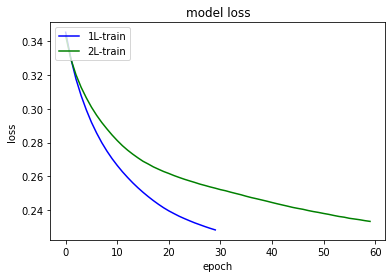

In [39]:
plt.plot(history2.history["loss"], '-b', label="1L-train")
plt.plot(history3.history["loss"], '-g', label="2L-train")
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="upper left")
plt.show()

In [40]:
# Computando as métricas para o teste
score3 = model3.evaluate(X_val, y_val, verbose=0)

print("Rede rasa")
print("--------")
print("Falsos negativos: ", score2[1])
print("Falsos positivos: ", score2[2])
print("Verdadeiros negativos: ", score2[3])
print("Verdadeiros positivos: ", score2[4])
print("Precisao: %.3f" % score2[5])
print("Revocacao: %.3f\n" % score2[6])

print("Rede profunda")
print("--------")
print("Falsos negativos: ", score3[1])
print("Falsos positivos: ", score3[2])
print("Verdadeiros negativos: ", score3[3])
print("Verdadeiros positivos: ", score3[4])
print("Precisao: %.3f" % score3[5])
print("Revocacao: %.3f" % score3[6])

Rede rasa
--------
Falsos negativos:  26.0
Falsos positivos:  25.0
Verdadeiros negativos:  114.0
Verdadeiros positivos:  58.0
Precisao: 0.699
Revocacao: 0.690

Rede profunda
--------
Falsos negativos:  17.0
Falsos positivos:  29.0
Verdadeiros negativos:  110.0
Verdadeiros positivos:  67.0
Precisao: 0.698
Revocacao: 0.798
